In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import tensorflow as tf
from efn.util.efn_util import setup_IO, find_convergence, model_opt_hps, easy_inds
from tf_util.stat_util import drawPoissonCounts
from efn.util.plot_util import exptrend, sattrend, load_V1_events, \
                      find_last_ind, get_latest_diagnostics, \
                      load_counts_spikes, cut_trailing_spikes, \
                      time_series_contour
import scipy.io as sio
from tf_util.families import family_from_str

import os

matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 28}

matplotlib.rc('font', **font)


exp_fam = 'lgc';
D = 20;

wsize = 50;
delta_thresh = 1e-10;

basedir = '/Users/sbittner/Documents/efn/efn/';
dir_str = exp_fam;

fam_class = family_from_str(exp_fam);
family = fam_class(D);

T_s = .02;
K = 100;
M = 200;
TIF_flow_type = 'PlanarFlowLayer'; 
nlayers = 30;
flow_dict = {'latent_dynamics':None, \
             'scale_layer':False, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers};
param_net_hps = {'L':5};
give_hint = False;
rs = 0;

2539 monkey 3, neuron 70, ori 8
nf /Users/sbittner/Documents/efn/efn/results/lgc/NF1_LogGaussianCox_D=20_flow=30P_ds=2539_rs=0/
MLE estimate
[0.035 0.02  0.03  0.06  0.1   0.065 0.085 0.05  0.04  0.025 0.02  0.065
 0.06  0.085 0.04  0.065 0.04  0.06  0.055 0.06 ]


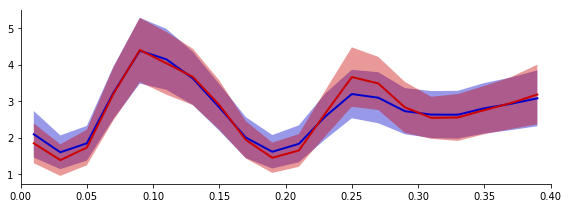

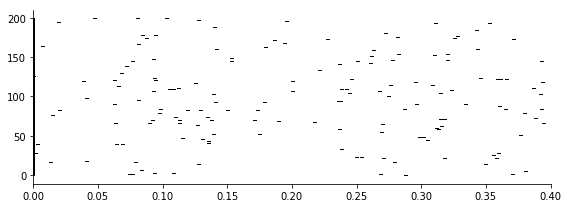

844 monkey 1, neuron 71, ori 5
nf /Users/sbittner/Documents/efn/efn/results/lgc/NF1_LogGaussianCox_D=20_flow=30P_ds=844_rs=0/
MLE estimate
[0.15  0.115 0.29  0.28  0.195 0.15  0.18  0.08  0.17  0.195 0.27  0.31
 0.175 0.18  0.14  0.09  0.125 0.175 0.2   0.27 ]


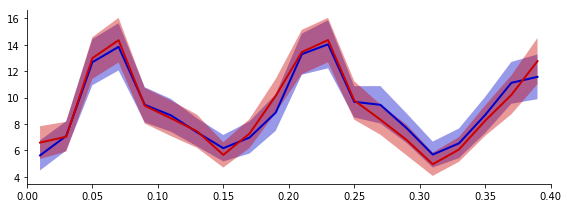

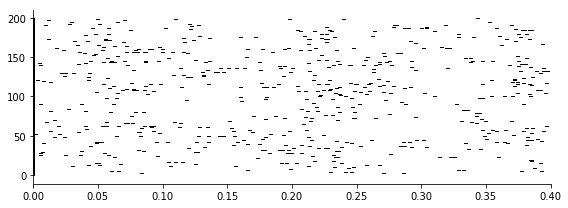

1697 monkey 2, neuron 59, ori 6
nf /Users/sbittner/Documents/efn/efn/results/lgc/NF1_LogGaussianCox_D=20_flow=30P_ds=1697_rs=0/
MLE estimate
[0.04  0.005 0.035 0.035 0.065 0.025 0.035 0.06  0.06  0.025 0.01  0.05
 0.04  0.045 0.02  0.065 0.06  0.025 0.03  0.07 ]


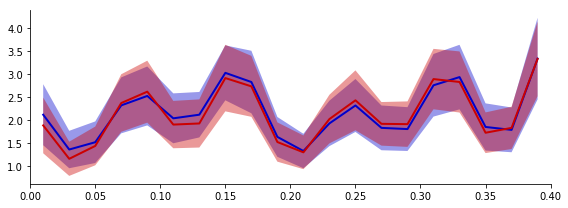

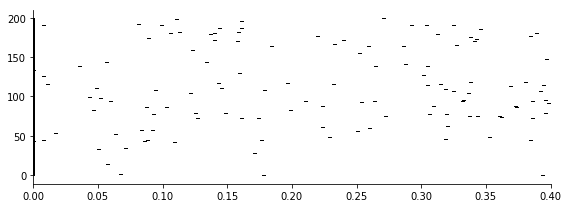

In [4]:
figwidth = 8;
figheight = 3;
figsize = (figwidth, figheight);

red = [.8,0,0];
blue = [0,0,.8];

prctiles = [5, 25, 50, 75, 95];
monkey_by_ind, neuron_by_ind, ori_by_ind = easy_inds();
efn_savedir = basedir + setup_IO(family, 'EFN', dir_str, 'eta', K, M, flow_dict, param_net_hps, \
                                             give_hint, rs);
npzfile = np.load(efn_savedir + 'results.npz');
efn_test_X = npzfile['test_X'];
efn_test_params = npzfile['test_params'][()];
inds = [1,2,3];
for i in range(len(inds)):
    efn_Z = np.exp(efn_test_X[inds[i],:,:,0]);
    data_ind = efn_test_params[inds[i]]['data_ind'];
    monkey = int(monkey_by_ind[data_ind]);
    neuron = int(neuron_by_ind[data_ind]);    
    ori = int(ori_by_ind[data_ind]);
    print(data_ind, 'monkey %d, neuron %d, ori %d' % (monkey, neuron, ori));
    assert(data_ind == family.resp_info_to_ind({'monkey':monkey, 'neuron':neuron, 'ori':ori}));
    # load NF model
    dist_info = {'dist_seed':data_ind};
    nf_savedir = basedir + setup_IO(family, 'NF1', dir_str, 'eta', 1, M, flow_dict, param_net_hps, \
                                             give_hint, rs, dist_info);
    print('nf', nf_savedir);
    nf_npzfile = np.load(nf_savedir + 'results.npz');
    nf_X = nf_npzfile['X'][0,:,:,0];
    nf_Z = np.exp(nf_X);
    
    # load counts spikes
    counts, spikes = load_counts_spikes(monkey, neuron, ori);
    print("MLE estimate");
    print(np.mean(counts,0)[:D]);
    spikes = cut_trailing_spikes(spikes, D, T_s);
    
    efn_rate = efn_Z / T_s;
    nf_rate = nf_Z / T_s;
    
    mean_efn_rate = np.mean(efn_rate, 0);
    std_efn_rate = np.std(efn_rate, 0);
    
    mean_nf_rate = np.mean(nf_rate, 0);
    std_nf_rate = np.std(nf_rate, 0);
    
    T = mean_nf_rate.shape[0];
    t = np.linspace(0,(T-1)*T_s, T) + (T_s/2.0);
    
    
    
    fontsize= 14;
    plt.figure(figsize=figsize);
    plt.plot(t, mean_efn_rate, color=blue, lw=2);
    plt.plot(t, mean_nf_rate, color=red, lw=2);
    plt.fill_between(t, mean_efn_rate-std_efn_rate, mean_efn_rate+std_efn_rate,facecolor=blue, alpha=0.4,);
    plt.fill_between(t, mean_nf_rate-std_nf_rate, mean_nf_rate+std_nf_rate,facecolor=red, alpha=0.4,);

    plt.xlim([0.0,D*T_s]);
    
    #if (i==0):
    #    plt.legend(['EFN', 'NF'])
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout();
    #plt.savefig('/Users/sbittner/Documents/efn/efn/written/EFN_AISTATS2019/figs/fig4/%s_%d_rates.pdf' % (exp_fam, i+1), \
    #        dpi=300, transparent=True)
    plt.show();
    
    

    plt.figure(figsize=figsize);
    plt.eventplot(np.array(spikes), colors='k', orientation='horizontal', linewidths=4);
    #plt.xlabel('time (s)', fontsize=fontsize);
    #plt.ylabel('trial', fontsize=fontsize);
    plt.xlim([0.0,D*T_s]);
    ax = plt.gca();
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.tight_layout();
    #plt.savefig('/Users/sbittner/Documents/efn/written/EFN_AISTATS2019/figs/fig4/%s_%d_spikes.pdf' % (exp_fam, i+1), \
    #        dpi=300, transparent=True)
    plt.show();

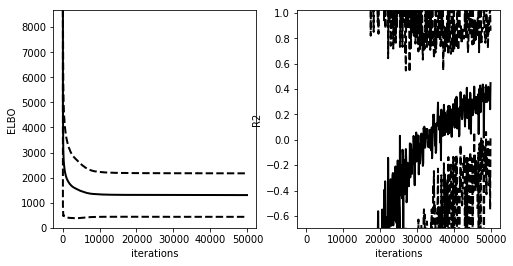

In [5]:
prctiles = [5, 25, 50, 75, 95];
monkey_by_ind, neuron_by_ind, ori_by_ind = easy_inds();
efn_savedir = basedir + setup_IO(family, 'EFN', dir_str, 'eta', K, M, flow_dict, param_net_hps, \
                                             give_hint, rs);
npzfile = np.load(efn_savedir + 'results.npz');

check_rate = npzfile['check_rate'];
test_elbos = npzfile['test_elbos'];
mean_efn_elbos = np.mean(test_elbos, 1);
std_efn_elbos = np.std(test_elbos, 1);

test_R2s = npzfile['train_R2s'];
mean_R2s = np.mean(test_R2s, 1);
std_R2s = np.std(test_R2s, 1);

last_ind = find_last_ind(test_elbos);
#final_ind = find_convergence(mean_elbos, last_ind+1, wsize, delta_thresh);
#if (final_ind is None):
#    print('didnt converge');
#    final_ind = last_ind;
final_ind = 500;
its = np.arange(0, check_rate*final_ind, check_rate);

plt.figure(figsize=(8, 4));
plt.subplot(1,2,1);
plt.plot(its, mean_efn_elbos[:final_ind], 'k', lw=2);
min_val = np.min(mean_efn_elbos[:final_ind]-std_efn_elbos[:final_ind]);
plt.plot(its, mean_efn_elbos[:final_ind]+std_efn_elbos[:final_ind],'k--', lw=2);
plt.plot(its, mean_efn_elbos[:final_ind]-std_efn_elbos[:final_ind],'k--', lw=2);
std_mag = std_efn_elbos[final_ind];
min_val = np.min(mean_efn_elbos);
max_val = min_val + 10*std_mag;
plt.ylim([min_val, max_val]);
plt.xlabel('iterations');
plt.ylabel('ELBO');

plt.subplot(1,2,2);
plt.plot(its, mean_R2s[:final_ind], 'k', lw=2);
min_val = np.min(mean_R2s[:final_ind]-std_R2s[:final_ind]);
plt.plot(its, mean_R2s[:final_ind]+std_R2s[:final_ind],'k--', lw=2);
plt.plot(its, mean_R2s[:final_ind]-std_R2s[:final_ind],'k--', lw=2);
std_mag = std_R2s[final_ind];
max_val = np.max(mean_R2s) + std_mag;
min_val = max_val - 4*std_mag;
plt.ylim([min_val, max_val]);
plt.xlabel('iterations');
plt.ylabel('R2');

plt.show()

In [7]:
model_str_prefix = 'NF1_LogGaussianCox_D=20_flow=30P'
lgcdir = '/Users/sbittner/Documents/efn/efn/results/lgc/';
dir_list = os.listdir(lgcdir);
num_dir_elems = len(dir_list);
num_models = 0;
model_strs = [];
nits = 0;
for i in range(num_dir_elems):
    model_str_i = dir_list[i];
    if (model_str_prefix in model_str_i):
        model_strs.append(model_str_i)
        fname_i = lgcdir + model_str_i + '/results.npz'
        npzfile = np.load(fname_i);
        train_elbos = npzfile['train_elbos'];
        nits_i = train_elbos.shape[0];
        if (nits_i > nits):
            nits = nits_i;
        num_models += 1;

    
        
final_ind = 500;

all_train_elbos = np.zeros((num_models, final_ind))
for i in range(num_models):
    fname_i = lgcdir + model_strs[i] + '/results.npz'
    npzfile = np.load(fname_i);
    all_train_elbos[i,:] = npzfile['train_elbos'][:final_ind,0];


In [8]:
print(all_train_elbos.shape)
mean_nf_elbos = np.mean(all_train_elbos, 0);
std_nf_elbos = np.std(all_train_elbos, 0);
its = np.arange(1, final_ind*check_rate+1, check_rate);


(298, 500)


In [9]:

mean_nf_elbos_var = mean_nf_elbos[:final_ind];

mean_efn_elbos_var = mean_efn_elbos[:final_ind];


In [11]:
efn_lgc_dir = '/Users/sbittner/Documents/efn/efn/results/lgc/EFN_LogGaussianCox_D=20_K=100_M=200_flow=30P_L=5_rs=0/';
npzfile = np.load(efn_lgc_dir + 'profile.npz');
efn_avgtime = np.mean(npzfile['times'][-10:]);

nf_lgc_dir = '/Users/sbittner/Documents/efn/efn/results/lgc/NF1_LogGaussianCox_D=20_flow=30P_ds=0_rs=0/';
npzfile = np.load(nf_lgc_dir + 'profile.npz');
nf_avgtime = np.mean(npzfile['times'][-10:]);

print('EFN average it', efn_avgtime);
print('NF1 average it', nf_avgtime)

EFN average it 0.1036653995513916
NF1 average it 0.03385097980499267


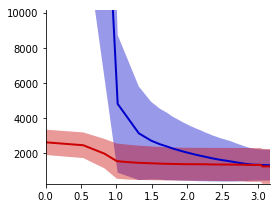

In [12]:
plt.figure(figsize=(4, 3));

efn_time = its*efn_avgtime;
plt.plot(np.log10(efn_time), mean_efn_elbos_var, color=blue, lw=2);
min_val = np.min(mean_efn_elbos_var-std_efn_elbos[:final_ind]);
plt.fill_between(np.log10(efn_time), mean_efn_elbos_var-std_efn_elbos[:final_ind], \
                  mean_efn_elbos_var+std_efn_elbos[:final_ind], \
                   facecolor=blue, alpha=0.4);

nf_time = its*nf_avgtime;
min_val = np.min(mean_nf_elbos_var-std_nf_elbos[:final_ind]);
plt.plot(np.log10(nf_time), mean_nf_elbos_var, color=red, lw=2);
plt.fill_between(np.log10(nf_time), mean_nf_elbos_var-std_nf_elbos[:final_ind], \
                  mean_nf_elbos[:final_ind]+std_nf_elbos[:final_ind], \
                   facecolor=red, alpha=0.4);
std_mag = std_nf_elbos[final_ind-1];
min_val = np.min(mean_nf_elbos) - std_mag
max_val = min_val + 10*std_mag;
plt.ylim([min_val, max_val]);
#plt.xlabel('time (s)');
#plt.ylabel('-ELBO');

plt.xlim([0,np.log10(1500)]);

#plt.legend(['EFN', 'NF']);
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
#plt.savefig('/Users/sbittner/Documents/efn/written/EFN_AISTATS2019/figs/fig4/lgc_elbo_optimization.pdf', \
#            dpi=300, transparent=True)
plt.show();

In [14]:
efn_lgc_dir = '/Users/sbittner/Documents/efn/efn/results/lgc/EFN_LogGaussianCox_D=20_K=100_M=200_flow=30P_L=5_rs=0/';
npzfile = np.load(efn_lgc_dir + 'profile.npz');
efn_avgtime = np.mean(npzfile['times'][-10:]);

nf_lgc_dir = '/Users/sbittner/Documents/efn/efn/results/lgc/NF1_LogGaussianCox_D=20_flow=30P_ds=0_rs=0/';
npzfile = np.load(nf_lgc_dir + 'profile.npz');
nf_avgtime = np.mean(npzfile['times'][-10:]);

print('EFN average it', efn_avgtime);
print('NF1 average it', nf_avgtime)

EFN average it 0.1036653995513916
NF1 average it 0.03385097980499267


/Users/sbittner/anaconda/envs/efn/lib/python3.6/site-packages/ipykernel/__main__.py:13: RuntimeWarning: divide by zero encountered in double_scalars


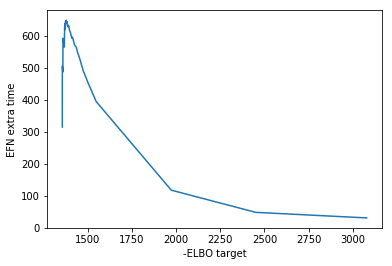

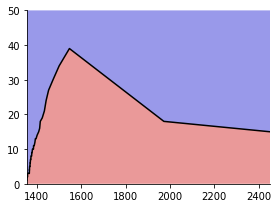

In [16]:
nits = 150;
its = np.arange(nits);
extra_times = np.zeros((nits,));
num_datasets = np.zeros((nits,));
for i in range(nits):
    efn_better_its = np.where(mean_efn_elbos < mean_nf_elbos[i])[0];
    
    if (len(efn_better_its) > 0):
        efn_it = efn_better_its[0]*check_rate;
        nf_it = i*check_rate;
        extra_time = (efn_avgtime*efn_it - nf_it*nf_avgtime);
        extra_times[i] = extra_time;
        num_datasets[i] = np.ceil((efn_avgtime*efn_it - nf_it*nf_avgtime) / (nf_it*nf_avgtime));
    else:
        extra_times[i] = np.nan;
plt.figure();
plt.plot(mean_nf_elbos[:nits], extra_times);
plt.xlabel('-ELBO target');
plt.ylabel('EFN extra time');
plt.show();

ymax = 50.0;
plt.figure(figsize=(4,3));
plt.plot(mean_nf_elbos[:nits], num_datasets, 'k');
plt.fill_between(mean_nf_elbos[:nits], num_datasets, ymax*np.ones((nits,)), \
                   facecolor=blue, alpha=0.4);
plt.fill_between(mean_nf_elbos[:nits], np.zeros((nits,)), num_datasets,  \
                   facecolor=red, alpha=0.4);
#plt.xlabel('-ELBO target');
#plt.ylabel('num datasets');
plt.xlim([mean_nf_elbos[nits-1], mean_nf_elbos[1]]);
plt.ylim([0, 50]);
ax = plt.gca();
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.tight_layout();
plt.savefig('/Users/sbittner/Documents/efn/written/EFN_AISTATS2019/figs/fig4/EFN_decision_boundary.pdf', \
            dpi=300, transparent=True)
plt.show();
    

In [ ]:
print(extra_times)

In [3]:
print(mean_nf_elbos)


NameError: name 'mean_nf_elbos' is not defined

(500,)
[3763.59541316 3763.64241988 3763.55974272 3763.72478671 3763.66927285
 3763.67902778 3763.63836906 3763.59078834 3763.63605487 3763.69272596]


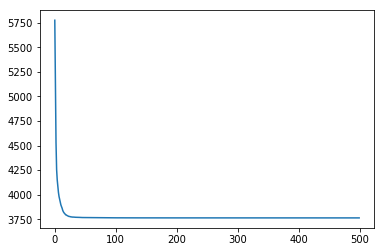

In [148]:
nf_elbo = all_train_elbos[0,:];
print(nf_elbo.shape);
plt.plot(nf_elbo);
print(nf_elbo[-10:])